<a href="https://colab.research.google.com/github/JulianOmar/HPC/blob/main/Cuaderno_2_Miercoles_grupo8_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cuaderno 2 - Miércoles - Grupo 8: Ajustar el espectro de color

##Introducción

En este cuaderno se intentará mostrar el potencial de procesamiento que nos provee la GPU comparativamente a la CPU. Por tal fundamento, desarrollamos un filtro propio que se basa en la modificación del espectro de color mediante identificar los píxeles de color rojo, verde o azul y realzarlos (según elección del usuario) , asimismo es viable obtener la imagen resultante al utilizar su escala de grises. 

###Ajustar el espectro de color

El ajuste de corrección espectro de color se realizado por medio de la ingreso del factor de intensidad de color que se desea aplicar incrementando o disminuyendo el valor individual de cada color RGB

###Escala de Grises

Las conversiones entre las imágenes de color y las imágenes en escala de grises no son enteramente directas. El ajuste de escala de grises se basa en la multiplicación de cada elemento por 3 constantes definidas: Alfa, Beta y Gamma. Este proceso sustrae toda la información de color que tiene cada píxel y nos deja una división de 255 niveles entre el blanco y el negro. Estas 3 constantes se obtienen como la división entre los canales RGB y el negro:  
   
  **Alfa**: Separación entre el rojo y el negro. (0.299)  
  **Beta**: Separación entre el verde y el negro. (0.599)   
  **Gamma**: Separación entre el azul y el negro. (0.111)  
  
  De tal manera que tenemos que:

<p align=center>$ 
G = 
 \begin{pmatrix} 
  (g_{1,1},g_{1,1}, g_{1,1})  & \cdots & (g_{1,n},g_{1,n}, g_{1,n}) \\
  \vdots  & \ddots & \vdots  \\
  (g_{m,1},g_{m,1}, g_{m,1}) & \cdots & (g_{m,n},g_{m,n}, g_{m,n})
 \end{pmatrix} 
 $
 </p>
 
$
g_{ij} = αr_{ij}, βg_{ij} y γb_{ij}
$

i = 1, 2, 3, ..., m y j = 1, 2, 3, ...,n  
  En donde los valores de α, β y γ son las siguientes constantes: 
α = 0.299 β = 0.599 γ = 0.11

##Armado del ambiente

Debido a que vamos a ejecutar código tanto en CPU como en GPU, necesitamos tener unas consideraciones previas.

1. Primero que nada hay que habilitar el entorno GPU.

  Para esto hay que ir a **Entorno de ejecución > Cambiar tipo de entorno de ejecución**. <br>Seleccionar GPU como *acelerador de hardware* y luego guardar.
2. Luego debemos instalar **OpenCL [2]** ya que vamos a trabajar con ésta biblioteca.
  <br>Para ello debemos ejecutar la siguiente instrucción:

In [ ]:
!pip install pycuda

3. Ingresar url de una imagen a la cual aplicarle los filtros.
4. Seleccionamos la intensidad de cada color que se desea aplicar a la imagen y si se desea obtener la imagen en escal de grises.

In [ ]:
#@title Filtro para realzar color RGB
#@markdown Ingrese la URL de la imagen que desea procesar: 

url_imagen = "https://github.com/JulianOmar/HPC/blob/main/Recursos/pexels-sharon-mccutcheon.jpg?raw=true" #@param {type: "string"}


!wget {url_imagen} -O imagen.jpg


#@markdown Seleccionar el color que desea realzar:
 
color_rojo = 63 #@param {type:"slider", min:-100, max:100, step:1}
color_verde = 74 #@param {type:"slider", min:-100, max:100, step:1}
color_azul = 100 #@param {type:"slider", min:-100, max:100, step:1}

escala_de_grises = False #@param {type:"boolean"}

#@markdown ---
#---------------------------------------------------------------------------------------


##Desarrollo CPU

Importamos los módulos

In [ ]:
import numpy
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime

Imagen del filtro: imagen.jpg -RGB- [5616, 3744]


Tiempo de conversión de imagen: 389871.919 [ms]
Tiempo Total: 391543.111 [ms]


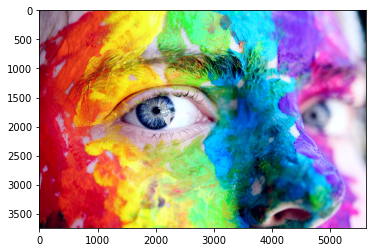

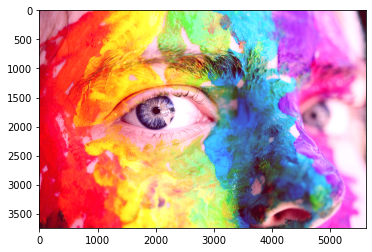

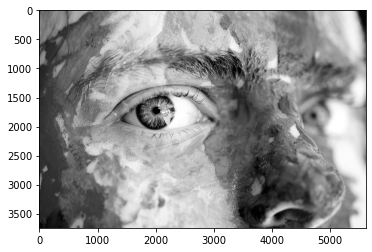

In [46]:
%matplotlib inline
alfa = 0.299
beta = 0.599
gamma = 0.111
# Tiempo total de ejecución
tiempo_total = datetime.now()
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 

#Obtenemos las dimensiones de la imagen
img_ancho, img_alto = image.size

# Convierto la imagen comprimida en JPEG/PNG a array.
img_pic_cpu = numpy.asarray(image)
img_pic_cpu = img_pic_cpu.astype( numpy.int32() )

# Genero el array resultado (3 pixeles usa RGB * (el tamaño del array)).
img_picR_cpu = numpy.empty_like( img_pic_cpu)
img_picR_cpu_g = numpy.empty_like( img_pic_cpu)

# Muestro los atributos de la imagen y como se ve.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )


#Defino las funciones de realce
def ajustar_espectro():
  for y in range(0, img_alto):
    for x in range(0, img_ancho):
      pixelrojo, pixelverde, pixelazul = img_pic_cpu[y][x]   

      nvopixelrojo = (pixelrojo + color_rojo)
      nvopixelverde = (pixelverde + color_verde)
      nvopixelazul = (pixelazul + color_azul)
      img_picR_cpu[y][x] = [nvopixelrojo, nvopixelverde, nvopixelazul]

def escala_gris():
  for y in range(0, img_alto):
    for x in range(0, img_ancho):
      pixel_R, pixel_G, pixel_B = img_pic_cpu[y][x]
      escala_de_grises = pixel_R*alfa + pixel_G*beta + pixel_B * gamma
      img_picR_cpu_g[y][x] = [escala_de_grises,escala_de_grises,escala_de_grises]
      


# Muestro la imagen antes de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_pic_cpu )

tiempo_img = datetime.now()
ajustar_espectro()
if escala_de_grises:
  escala_gris()
tiempo_img = datetime.now() - tiempo_img

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot = plt.imshow( img_picR_cpu )
if escala_de_grises:
  plt.figure()
  imgplot = plt.imshow( img_picR_cpu_g )
tiempo_total = datetime.now() - tiempo_total

print( "Tiempo de conversión de imagen:", tiempo_en_ms( tiempo_img   ), "[ms]" )
print( "Tiempo Total:",                   tiempo_en_ms( tiempo_total ), "[ms]" )

##Desarrollo GPU

Para el desarrollo en GPU, primero ejecutamos el código que genera el Kernel necesario para la aplicación de los filtros.

In [38]:
#Importamos los módulos
from datetime import datetime
import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

Imagen del filtro: imagen.jpg -RGB- [5616, 3744]
Thread: [ 16 , 9  ], Bloque : [ 351 , 416 ]
Total de Thread: [ 5616 , 3744  ]  =  21026304


Tiempo GPU  :  0.313 [ms]
Tiempo TOTAL:  1893.7849999999999 [ms]


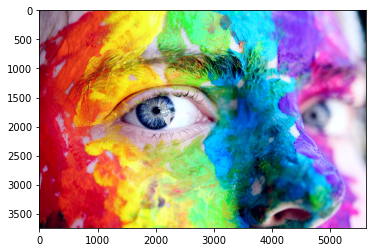

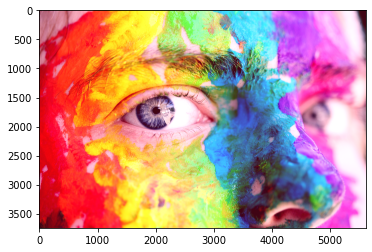

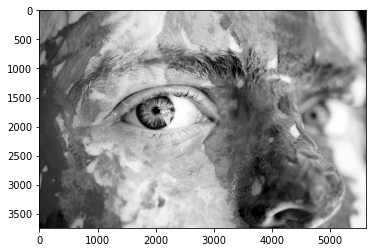

In [56]:
%matplotlib inline
escala_de_grises = True
tiempo_total = datetime.now()

# --------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)
img_R_cpu_G = numpy.empty_like( img_O_cpu)
# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )
img_R_gpu_G = cuda.mem_alloc( img_R_cpu_G.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )
cuda.memcpy_htod( img_R_gpu_G, img_R_cpu_G )

# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule(""" 
__global__ void kernel_img( int color_rojo, int color_verde, int color_azul, int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  
  float nvopixelrojo;
  float nvopixelverde;
  float nvopixelazul;
 
  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el nuevo color para el pixel a partir de los componentes.
    nvopixelrojo =  (float) ((img_O[ ((idx+(idy*ancho))*3)+0 ] + color_rojo)); //Rojo
    nvopixelverde = (float) ((img_O[ ((idx+(idy*ancho))*3)+1 ] + color_verde)); //Verde
    nvopixelazul =  (float) ((img_O[ ((idx+(idy*ancho))*3)+2 ] + color_azul)); //Azul

    // Escribo el nuevo color del pixel.
    img_R[(idx+(idy*ancho))*3+0] = (int) nvopixelrojo;
    img_R[(idx+(idy*ancho))*3+1] = (int) nvopixelverde;
    img_R[(idx+(idy*ancho))*3+2] = (int) nvopixelazul;
  }
}

__global__ void kernel_img_grises( int ancho, int alto, int *img_O, int *img_R_G )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  
  float alfa = 0.299;
  float beta = 0.599;
  float gamma = 0.111;
  float nvopixelrojo;
  float nvopixelverde;
  float nvopixelazul;
  float escala_de_grises;
 
  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el nuevo color para el pixel a partir de los componentes.
    nvopixelrojo =  (float) ((img_O[ ((idx+(idy*ancho))*3)+0 ] * alfa)); //Rojo
    nvopixelverde = (float) ((img_O[ ((idx+(idy*ancho))*3)+1 ] * beta)); //Verde
    nvopixelazul =  (float) ((img_O[ ((idx+(idy*ancho))*3)+2 ] * gamma)); //Azul

    escala_de_grises = nvopixelrojo  + nvopixelverde + nvopixelazul;
    // Escribo el nuevo color del pixel.
    img_R_G[(idx+(idy*ancho))*3+0] = (int) escala_de_grises;
    img_R_G[(idx+(idy*ancho))*3+1] = (int) escala_de_grises;
    img_R_G[(idx+(idy*ancho))*3+2] = (int) escala_de_grises;
  }
}
""") 

# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: " + img_nombre + " -" + image.mode + "- [" + str(img_ancho) + ", " + str(img_alto ) + "]" )  

# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")
kernel_grises = module.get_function("kernel_img_grises")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = numpy.int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 9
dim_bloque_y = numpy.int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

print( "Thread: [", dim_hilo_x, ",", dim_hilo_y, " ], Bloque : [", dim_bloque_x, ",", dim_bloque_y, "]" )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )

tiempo_img = datetime.now()

kernel( numpy.int32(color_rojo),numpy.int32(color_verde),numpy.int32(color_verde), numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )
if escala_de_grises:
  kernel_grises(  numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu_G, block=( dim_hilo_x, dim_hilo_y, 1 ), grid=(dim_bloque_x, dim_bloque_y,1) )
tiempo_img = datetime.now() - tiempo_img

# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

if escala_de_grises:
  cuda.memcpy_dtoh( img_R_cpu_G, img_R_gpu_G )
  plt.figure()
  imgplot=plt.imshow( img_R_cpu_G )

tiempo_total = datetime.now() - tiempo_total

print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )
print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )

##Métricas

Tiempos   (ms)  | CPU           | GPU
----------------|---------------|----------
Tiempo parcial  | 183152.525    |   0.171  
Tiempo Total    | 184509.312    |  67.335 

##Conclusiones

A partir de los resultados obtenidos en las métricas, se ve que el tiempo de ejecución total del programa utilizando la GPU para la imagen propuesta es considerablemente menor del tiempo de ejecución total utilizando sólo la CPU. Es decir, aproximadamente 2500 veces menos. Ésto nos da una clara demostración de la mejora en tiempo que nos proveen los threads.
<br>
Similar a lo concluído en el ejercicio 1, si se trata de imágenes pequeñas, por ejemplo una imagen de 256x256 píxeles, la diferencia entre ambos algoritmos será despreciable, ya que el overhead de la planificación de threads termina equiparando los tiempos totales.
<br>
**Pero también es importante destacar que cuanto mayor es la imagen, mayor también será la brecha entre ambos.** De usar una imagen de menor tamaño los resultados no serían tan dispares como los obtenidos.

##Bibliografía
*   [1] Síntesis digital de color utilizando tonos de gris, Ing. Jesús Gustavo Flores Eraña [PDF](https://ninive.uaslp.mx/xmlui/bitstream/handle/i/2264/MCA1SDC00901.pdf?sequence=1&isAllowed=y://)
*   [2] PyCUDA Documentation: [doc](https://documen.tician.de/pycuda/)
*   [3] 2009, SINTESIS DIGITAL DE COLOR UTILIZANDO TONOS DE GRIS, ING. JESÚS GUSTAVO FLORES ERAÑA : [PDF](https://ninive.uaslp.mx/xmlui/bitstream/handle/i/2264/MCA1SDC00901.pdf?sequence=1&isAllowed=y)